In [32]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import network_summary as ns
import csv

In [33]:
'''Reading the input routes file and creating a dataframe.'''
air_data = pd.read_csv('routes_v3.txt', sep=",", header=None)
air_data.columns = ["Airline_Code", "Airline_Id", "Source_Code", "Source_Id","Destination_Code","Destination_ID","Codeshare","Stops","Equip_Code"]

In [34]:
'''Cleaning and filtering the data to get data for assigned airline''' 
air_data=air_data[air_data['Airline_Code']=='AL54']
air_data=air_data.replace({'\n': ''}, regex=True)

In [35]:
'''Creating a dictionary to convert ICAO airport codes to integers'''
src=pd.DataFrame(air_data['Source_Code'].unique())
dst=pd.DataFrame(air_data['Destination_Code'].unique())
comb=pd.merge(src,dst,how='outer')
lst=list(range(1,len(comb)+1))
airport_dict=dict(zip(comb[0].tolist(), lst))

In [36]:
'''Removing the return flight routes from the data to get unidirectional routes. Writing the final dataframe to a csv file'''
air_data['Source_Code'].replace(airport_dict, inplace=True)
air_data['Destination_Code'].replace(airport_dict, inplace=True)
df=air_data[['Source_Code','Destination_Code']]
df1=pd.DataFrame(np.sort(df.values, axis=1), columns=df.columns).drop_duplicates()
air_data=air_data.merge(df1, how='inner')
air_data.to_csv('my_airline.csv', encoding='utf-8')

In [37]:
#reverse dictionary, will be used to get the airport codes from the integer values
airport_dict=dict(zip(lst, comb[0].tolist()))

In [38]:
'''Creation of the graph data structure'''
G=nx.Graph()
G = nx.from_pandas_edgelist(air_data, 'Source_Code', 'Destination_Code')

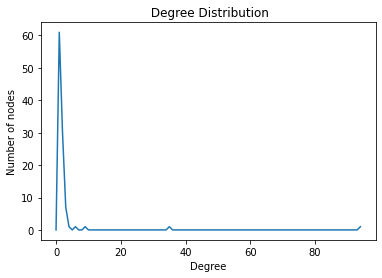

In [39]:
'''Finding the graph characteristics and writing it to a file'''
n_nodes=G.number_of_nodes()
n_edges=G.number_of_edges()
density=nx.density(G)
connected_comp=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
diameter=nx.diameter(G)
min_deg, max_deg, avg_deg, stdev_deg, deg=ns.degree_statistics(G)

fieldnames = ['number_of_nodes', 'number_of_edges', 'density',
              'number_of_connected_comp', 'connected_comps','diameter',
              'min_degree','max_degree', 'avg_degree','std_dev_degree']
rows=[[n_nodes,n_edges,density,len(connected_comp),connected_comp,diameter,min_deg,max_deg,avg_deg,stdev_deg]]
with open('deg_stats.csv', 'w') as csvfile:  
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(fieldnames) 
        
    # writing the data rows 
    csvwriter.writerows(rows)

ns.plot_degree_histogram_v3(G, "", '')

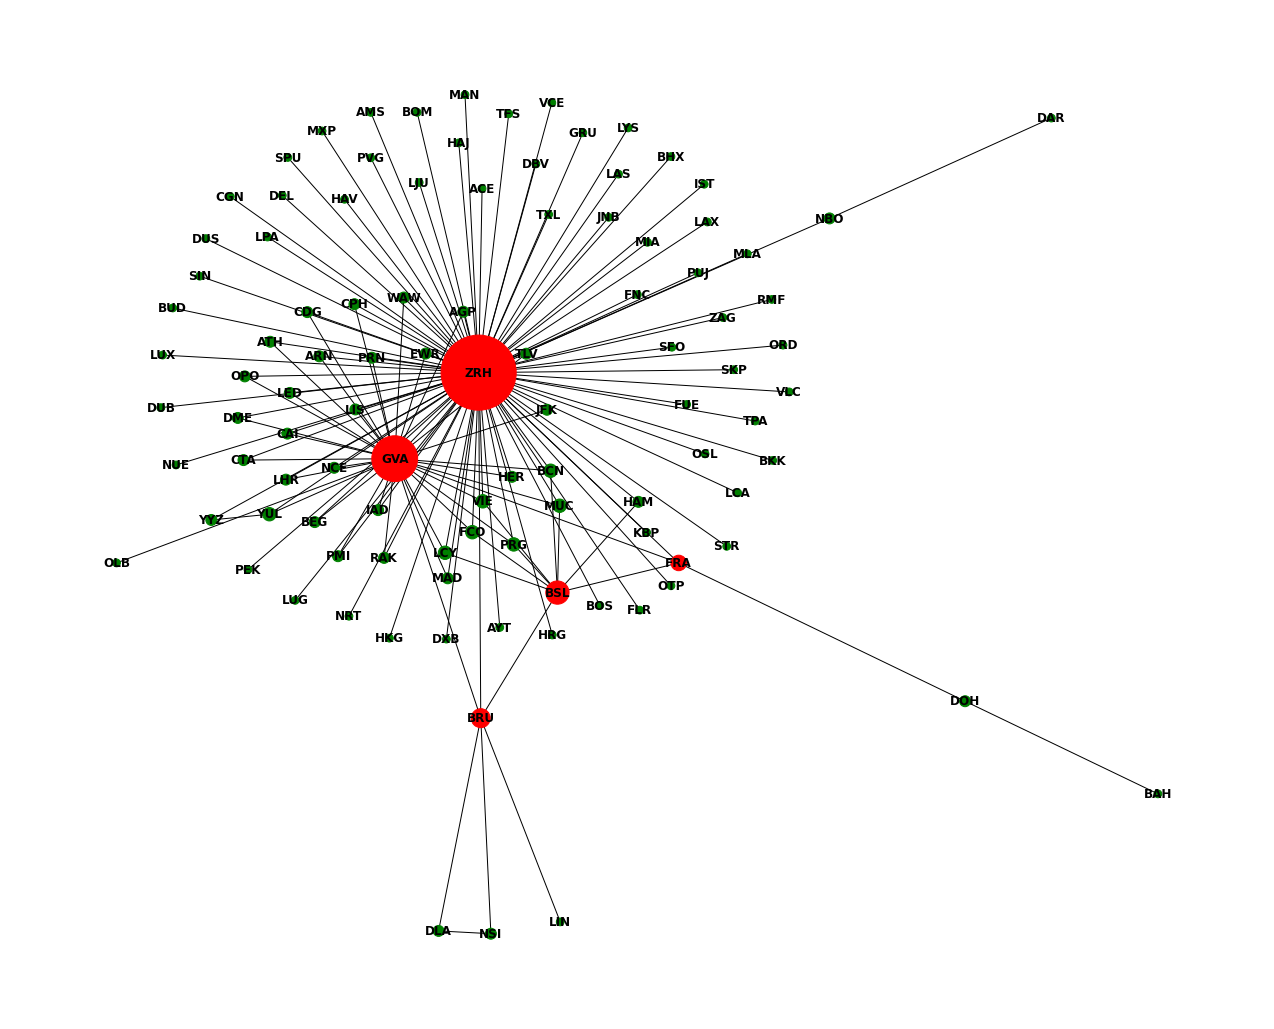

<Figure size 432x288 with 0 Axes>

In [40]:
'''Visualising the graph data structure'''
d = dict(G.degree)
color_map = []
for node in G.nodes:
    if len(G[node]) > np.ceil(avg_deg):
        color_map.append('red')
    else: 
        color_map.append('green')
plt.figure(figsize=(17.5, 14.1))
pos = nx.spring_layout(G, seed=3123794552)
nx.draw(G, pos, nodelist=d.keys(), node_size=[v * 60 for v in d.values()], node_color=color_map)#,labels=airport_dict,with_labels=True)
nx.draw_networkx_labels(G, pos, labels=airport_dict, font_size=12, font_weight='bold')
plt.show()
plt.savefig("AL54_graph.png")

In [41]:
'''Finding the top hubs using different algorithms and writing it to csv file''' 
leaderboard = {}
for x in G.nodes:
 leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2.rename(index=airport_dict, inplace=True)
tophub_manual=df2.head()
tophub_manual.reset_index(level=0, inplace=True)
tophub_manual = tophub_manual.rename({'index': 'Manual Analysis'}, axis=1)

deg_centrality = nx.degree_centrality(G)
top=sorted(deg_centrality, key=deg_centrality.get, reverse=True)[:5]
lst=[ airport_dict.get(item,item) for item in top ]
tophub_deg=pd.DataFrame(lst, columns=['Degree Centrality'])

close_centrality = nx.closeness_centrality(G)
top_cl=sorted(deg_centrality, key=deg_centrality.get, reverse=True)[:5]
lst=[ airport_dict.get(item,item) for item in top_cl ]
tophub_cl=pd.DataFrame(lst, columns=['Closeness Centrality'])

bet_centrality = nx.betweenness_centrality(G, normalized = True, endpoints = False)
top_bet=sorted(deg_centrality, key=deg_centrality.get, reverse=True)[:5]
lst=[ airport_dict.get(item,item) for item in top_bet ]
tophub_bet=pd.DataFrame(lst, columns=['Betweenness Centrality'])

top_hubs=pd.concat([tophub_manual, tophub_deg, tophub_cl, tophub_bet], axis=1)
top_hubs=top_hubs[['Manual Analysis','Degree Centrality','Closeness Centrality','Betweenness Centrality','connections']]
top_hubs.to_csv('my_airline_top_hubs.csv', encoding='utf-8')